In [11]:
import pytesseract as pt

pt.pytesseract.tesseract_cmd = r'C:\\Program Files\Tesseract-OCR\tesseract'

In [12]:
import fitz
import io
from PIL import Image
import os
from paddleocr import PaddleOCR
import re
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt

In [13]:
ocr = PaddleOCR(use_angle_cls=True, lang='korean')

[2025/04/28 14:48:36] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\zero/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\zero/.paddleocr/whl\\rec\\korean\\korean_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_sha

In [14]:
def sanitize_filename(name):
    # 파일명에 쓸 수 없는 문자 제거 및 공백, 줄바꿈 처리
    name = re.sub(r'[\\/*?:"<>|]', "", name)
    name = name.strip().replace("\n", "")
    if not name:
        name = "unknown"
    return name

In [15]:
doc = fitz.open("answer.pdf")

In [24]:
def extract_images_and_names():
    doc = fitz.open("answer.pdf")

    saved_names = set()
    for page_num, page in enumerate(doc):
        print(f'page {page_num}')
        image_list = page.get_images(full=True)

        image_bboxes = []
        for img in image_list:
            xref = img[0]
            rects = page.get_image_rects(xref)
            if rects:
                image_bboxes.append((xref, rects[0]))

        for img_idx, (xref, img_rect) in enumerate(image_bboxes):
            img_info = doc.extract_image(xref)
            img_bytes = img_info["image"]
            img_ext = img_info["ext"]
            img_path = os.path.join('./character_images', f"tmp_{page_num}_{img_idx}.{img_ext}")
            with open(img_path, "wb") as f:
                f.write(img_bytes)

            name_rect = fitz.Rect(
                img_rect.x0,
                img_rect.y1,
                img_rect.x1,
                img_rect.y1 + 50
            )

            page_pix = page.get_pixmap(dpi=300)
            page_img = Image.frombytes("RGB", [page_pix.width, page_pix.height], page_pix.samples)
            scale = page_pix.width / page.rect.width

            crop_box = (
                int(name_rect.x0 * scale),
                int(name_rect.y0 * scale), 
                int(name_rect.x1 * scale),
                int(name_rect.y0 * scale) + 80,
            )

            name_img = page_img.crop(crop_box)
            plt.imshow(name_img)

            # name_text = pt.image_to_string(name_img, lang='kor').strip()
            result = ocr.ocr(np.array(name_img), cls=True)
            print(result)
            name_text = result[0][0][1][0]
            print(name_text)
            # print(result)
            # for line in result:
            #     for box, (text, confidence) in line:
            #         print(f"인식된 텍스트: {text}, 신뢰도: {confidence}")

            name_text = sanitize_filename(name_text)

            orig_name = name_text
            count = 1
            while name_text in saved_names:
                name_text = f"{orig_name}_{count}"
                count += 1
            saved_names.add(name_text)

            final_img_path = os.path.join('./character_images', f"{name_text}.{img_ext}")
            os.rename(img_path, final_img_path)
            print(f"캐릭터 추출: {final_img_path}")

page 0
[2025/04/28 14:50:15] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0164031982421875
[2025/04/28 14:50:15] ppocr DEBUG: cls num  : 1, elapsed : 0.010023117065429688
[2025/04/28 14:50:15] ppocr DEBUG: rec_res num  : 1, elapsed : 0.14415311813354492
[[[[[45.0, 30.0], [111.0, 33.0], [110.0, 72.0], [43.0, 68.0]], ('I러A', 0.6128821969032288)]]]
I러A
캐릭터 추출: ./character_images\I러A.png
[2025/04/28 14:50:15] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.017229557037353516
[2025/04/28 14:50:15] ppocr DEBUG: cls num  : 1, elapsed : 0.010001420974731445
[2025/04/28 14:50:15] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1464250087738037
[[[[[40.0, 27.0], [111.0, 32.0], [109.0, 73.0], [38.0, 68.0]], ('빅스', 0.9720197916030884)]]]
빅스
캐릭터 추출: ./character_images\빅스.png
[2025/04/28 14:50:15] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.009945869445800781
[2025/04/28 14:50:15] ppocr DEBUG: cls num  : 1, elapsed : 0.017872095108032227
[2025/04/28 14:50:15] ppocr DEBUG: rec_res num  : 1, elapsed : 0.1598665714

TypeError: 'NoneType' object is not subscriptable

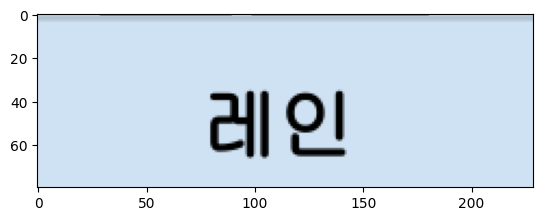

In [25]:
extract_images_and_names()

In [ ]:
saved_names = set()
for page_num, page in enumerate(doc):
    blocks = page.get_text("dict")["blocks"]
    # image_blocks = [b for b in blocks if b['type'] == 1]
    image_blocks = page.get_images(full=True)

    text_blocks = [b for b in blocks if b['type'] == 0]
    for img_idx, img_block in enumerate(image_blocks):
        pix = fitz.Pixmap(doc, img_block[0])
        if pix.n >= 5:
            pix = fitz.Pixmap(fitz.csRGB, pix)

        img_path = f"char_{page_num}_{img_idx}.png"
        pix.save(img_path)
        pix = None

        candidate_names = []
        for tb in text_blocks:
            tb_rect = fitz.Rect(tb['bbox'])
            vertical_gap = tb_rect.y0 - img_rect.y1
            horizontal_overlap = min(tb_rect.x1, img_rect.x1) - max(tb_rect.x0, img_rect.x0)
            if 5 < vertical_gap < 60 and horizontal_overlap > 0:
                candidate_names.append((vertical_gap, tb_rect, tb))

        if not candidate_names:
            final_img_path = os.path.join('character_images', f"unknown_{page_num}_{img_idx}.png")
            os.rename(img_path, final_img_path)
            print(f"이름 없음: {final_img_path}")
            continue
    
        candidate_names.sort()

        _, name_rect, name_block = candidate_names[0]
        page_pix = page.get_pixmap(dpi=300)
        page_img = Image.frombytes("RGB", [page_pix.width, page_pix.height], page_pix.samples)

        scale = page_pix.width / page.rect.width
        crop_box = (
            int(name_rect.x0 * scale),
            int(name_rect.y0 * scale),
            int(name_rect.x1 * scale),
            int(name_rect.y1 * scale),
        )
        name_img = page_img.crop(crop_box)

        name_text = pt.image_to_string(name_img, lang='kor').strip()
        name_text = sanitize_filename(name_text)

        orig_name = name_text
        count = 1
        while name_text in saved_names:
            name_text = f"{orig_name}_{count}"
            count += 1
        saved_names.add(name_text)

        final_img_path = os.path.join('character_images', f"{name_text}.png")
        os.rename(img_path, final_img_path)
        print(f"캐릭터 추출: {final_img_path}")

In [ ]:
def extract_text_with_ocr(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))

    width, height = image.size
    bottom_area = image.crop((0, height * 0.8, width, height))
    text = pytesseract.image_to_string(bottom_area, lang='kor+eng')
    return text.strip()

In [ ]:
def sanitize_filename(text):
    return re.sub(r'[\\/*?:"<>|]', "", text).strip()

In [ ]:
def find_closest_text_below_image(image, text_list, x_tolerance=100, max_y_distance=100):
    """
    이미지 바로 아래에 가장 가까운 텍스트 한 개만 반환
    - x_tolerance: 이미지 중심과 텍스트 중심 x축 허용 오차 (픽셀)
    - max_y_distance: 이미지 하단과 텍스트 상단 사이 최대 거리 (픽셀)
    """
    img_center_x = (image["rect"].x0 + image["rect"].x1) / 2
    img_bottom_y = image["rect"].y1
    
    candidates = []
    for text in text_list:
        text_center_x = (text["rect"].x0 + text["rect"].x1) / 2
        text_top_y = text["rect"].y0
        
        # x축 정렬 범위 내 + 텍스트가 이미지 아래에 위치 + y축 거리 제한
        if abs(text_center_x - img_center_x) <= x_tolerance and 0 < (text_top_y - img_bottom_y) <= max_y_distance:
            distance = text_top_y - img_bottom_y
            candidates.append((text, distance))
    
    if not candidates:
        return None
    
    # y축 거리가 가장 가까운 텍스트 반환
    closest_text = min(candidates, key=lambda x: x[1])[0]
    return closest_text


In [ ]:
def extract_character_info(pdf_path, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    doc = fitz.open(pdf_path)
    character_data = []
    
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        
        images = page.get_images(full=True)

        image_list = []
        for img_idx, img in enumerate(images):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            image_ext = base_image["ext"]

            img_rect = fitz.Rect(img[1:5])
            image_list.append({
                "xref": xref,
                "rect": img_rect,
                "bytes": image_bytes,
                "ext": image_ext,
                "center_x": (img_rect.x0 + img_rect.x1) / 2,
                "center_y": (img_rect.y0 + img_rect.y1) / 2
            })

        text_blocks = page.get_text("blocks")
        text_list = []
        for block in text_blocks:
            if block[6] == 0:
                text = block[4].strip()
                if text:
                    text_rect = fitz.Rect(block[:4])
                    text_list.append({
                        "text": text,
                        "rect": text_rect,
                        "center_x": (text_rect.x0 + text_rect.x1) / 2,
                        "center_y": (text_rect.y0 + text_rect.y1) / 2
                    })

        if image_list:
            x_coords = [img["center_x"] for img in image_list]
            x_clusters = cluster_coordinates(x_coords)
            
            for column_idx, x_range in enumerate(x_clusters):
                column_images = [img for img in image_list if x_range[0] <= img["center_x"] <= x_range[1]]
                
                column_images.sort(key=lambda x: x["center_y"])
    
                for img in column_images:
                    matched_text = find_text_below_image(img, text_list, x_range)
                    # matched_text = find_closest_text_below_image(img, text_list)
                    
                    if matched_text:
                        # img_filename = f"{matching_text['text']}_{page_num}_{img['xref']}.{img['ext']}"
                        img_filename = f"{sanitize_filename(matched_text['text'])}.{img['ext']}"
                        img_path = os.path.join(output_dir, img_filename)
                        
                        with open(img_path, "wb") as f:
                            f.write(img["bytes"])
                        
                        character_data.append({
                            "name": matched_text["text"],
                            "image_path": img_path
                        })
                        print(f"저장됨: {matched_text['text']} - {img_path}")
    
    return character_data

def cluster_coordinates(coords, threshold=20):
    """좌표를 클러스터링하여 열 감지"""
    coords = sorted(coords)
    clusters = []
    current_cluster = [coords[0]]
    
    for coord in coords[1:]:
        if coord - current_cluster[-1] > threshold:
            # 평균 중심점 계산
            avg = sum(current_cluster) / len(current_cluster)
            # 클러스터 범위 설정
            cluster_range = (avg - threshold, avg + threshold)
            clusters.append(cluster_range)
            current_cluster = [coord]
        else:
            current_cluster.append(coord)
    
    # 마지막 클러스터 처리
    if current_cluster:
        avg = sum(current_cluster) / len(current_cluster)
        cluster_range = (avg - threshold, avg + threshold)
        clusters.append(cluster_range)
    
    return clusters

def find_text_below_image(image, text_list, x_range):
    """이미지 아래에 위치한 텍스트 찾기"""
    candidates = []
    
    for text in text_list:
        if (x_range[0] <= text["center_x"] <= x_range[1] and text["rect"].y0 > image["rect"].y1):
            distance = text["rect"].y0 - image["rect"].y1
            candidates.append((text, distance))

    if candidates:
        return min(candidates, key=lambda x: x[1])[0]

    return None

In [ ]:
character_data = extract_character_info("answer.pdf", "character_images")
character_data